In [12]:
from chickpea.cma import CavityModeAnalysis
import legume
import numpy as np
import time

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


We setup the crystal cavity we are interested in simulating.

In [13]:
# Number of PhC periods in x and y directions
Nx, Ny = 12, 12


# Regular PhC parameters
a=1.0

dslab = 0.26/0.366
n_slab = 3.4
ra = 0.344


# Initialize a lattice and PhC
lattice = legume.Lattice([Nx*a, 0], [0, Ny*np.sqrt(3)/2*a])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx, Ny
for iy in range(ny):
    for ix in range(nx):
        if iy == 0 and ix in (-1 %nx,0,1):
            continue
        if iy in (1,-1 % ny) and ix in (0, -1 % nx):
            continue
        xp.append((ix + (iy%2)*0.5)*a)
        yp.append((iy*np.sqrt(3)/2)*a)

nc = len(xp)


we define some meta properties of the crystal.

In [14]:
super_periods = np.array((Nx*a, 2*Ny*np.sqrt(3)/2*a))
defect_margins = np.array([0.25,0.25])

# Define L3 PhC cavity with shifted holes
def cavity():
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic]
        xc = xp[ic]

        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
    return phc

phc = cavity()

Next, we construct the base lattice, the photonic crystal object, and the GME object:

In [15]:
a1 = np.array([a*0.5, a*np.sqrt(3)/2])
a2 = np.array([a*0.5, -a*np.sqrt(3)/2])

base_lattice = legume.Lattice(a1,a2)
base_phc = legume.PhotCryst(base_lattice)
base_phc.add_layer(d=dslab, eps_b=n_slab**2)
base_phc.layers[0].add_shape(legume.Circle(eps=1.0, r=ra))


We construct the cavity mode analysis object

In [16]:
cma = CavityModeAnalysis(phc, base_phc, super_periods, defect_margins, layer=0, gmax=6, base_gmax=3)

First lets find the band-gaps of the base crystal. This will give us an idea of where the cavity modes should be.

Band gap lower bound: 0.243921.
Band gap upper bound: 0.380139.
Band gap center: 0.312030.
Gap-midgap ratio: 0.436556.
The top of the air band is at k= (3.141593, -1.813799).
The bottom of the dielectric band is at k= (3.141593, 1.813799).



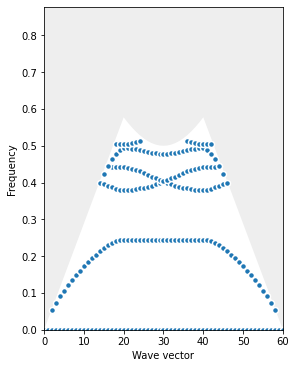

In [17]:
band_gaps, k_air, k_eps =cma.find_band_gaps(band_tol=0.1, order=np.array([0,3]), lc_trim=0.025)

gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])

legume.viz.bands(cma.base_gme,  trim_light_cone=True, lc_trim=0.025)

# With forethought we know there is only one band-gap for this crystal.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0], band_gaps[0][1], band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))

From this data we can deduce that we should be looking for cavity modes in the region
$0.25 \frac{\omega a}{2\pi c}-0.38\frac{\omega a}{2\pi c}$. In an optimization, we may want to use data like this
to tune the properties of the base crystal.

Now that we have the frequency region we are interested in we can setup the simulation on the super crystal.



In [18]:

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'numeig': 2, # We happen to know this is a good number to fill the band gap.
           'eig_solver': 'eigsh',
           'eig_sigma': 0.271, # We target the center of the band gap
           'compute_im': False # We only want to calculate the loss rates for cavity modes.
           }

# We simulate on a kpoint away of the light cone.
# Naturally we will only see cavity modes with fourier components at this point. For a full analysis
# it may be prudent to search in multiple places.

kpoints = np.array([[k_air[0]], [k_air[1]]])

%memit cma.gme.run(kpoints=kpoints, **options)

658.2768s total time for real part of frequencies, of which
  1.3930s for guided modes computation using the gmode_compute='exact' method
  81.0804s for inverse matrix of Fourier-space permittivity
  65.2231s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 29408.08 MiB, increment: 29311.95 MiB


Because we simulated outside the light cone we can filter cavity modes by
restricting the frequency range to the band gap.

In [19]:
arg_list =np.argwhere((cma.gme.freqs[0]<(band_gaps[0][1]))*(cma.gme.freqs[0]>band_gaps[0][0])).flatten()


We can further filter by modal volume.

In [20]:
V=[]
for arg in arg_list:
    V.append(cma.mode_volume(cma.gme, 'h', 'z', 0, arg, sample_scale=2))

V = np.array(V)

# With foresight we know 10 is a reasonable threshold to set.
arg_list = arg_list[np.argwhere(V < 10).flatten()]
V = V[np.argwhere(V < 10).flatten()]

In [21]:
freqs_im, _, _ = cma.gme.compute_rad(kind=0, minds=arg_list)

Q = cma.gme.freqs[0][arg_list]/(2*freqs_im[0])


Finally, knowing the mode volume and the Q factor of our we plot the magnitude of the electric field

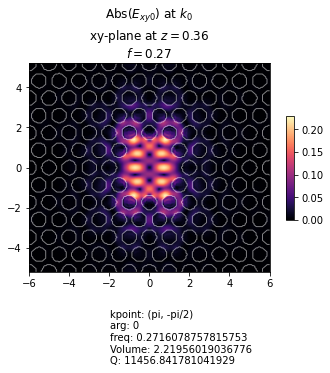

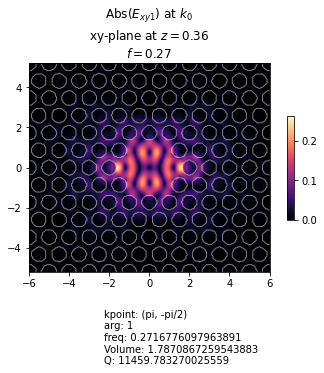

In [22]:
for i in range(arg_list.size):
    fig=legume.viz.field(cma.gme,'E', 0, arg_list[i],z=dslab/2, component='xy', val='abs', N1=200, N2=200, norm=True)
    fig.text(0.5,-0.25,
             "kpoint: (pi, -pi/2)" + "\n"
             + "arg: " + str(arg_list[i])+ "\n"
             + "freq: " + str(cma.gme.freqs[0][arg_list[i]]) + "\n"
             + "Volume: " + str(V[i]) + "\n"
             + "Q: " + str(Q[i]))

    fig.savefig("C:\\Users\\stephen\\PycharmProjects\\legume\\Cavity Docs\\Analysis Pics\\kpoint_(pi_-pi_2)" + "-freq_" + str(int(cma.gme.freqs[0][arg_list[i]]*1000))
             + "-"+str(time.time_ns())[5:-8], bbox_inches="tight")

Lets do the same thing at a second kpoint

In [23]:
kpoints = np.array([[k_air[0]], [k_eps[1]]])/2

cma.gme.run(kpoints=kpoints, **options)

arg_list =np.argwhere((cma.gme.freqs[0]<(band_gaps[0][1]))*(cma.gme.freqs[0]>band_gaps[0][0])).flatten()


V=[]
for arg in arg_list:
    V.append(cma.mode_volume(cma.gme, 'h', 'z', 0, arg, sample_scale=2))

V = np.array(V)

arg_list = arg_list[np.argwhere(V < 10).flatten()]
V = V[np.argwhere(V < 10).flatten()]

freqs_im, _, _ = cma.gme.compute_rad(kind=0, minds=arg_list)

Q = cma.gme.freqs[0][arg_list]/(2*freqs_im[0])

544.5025s total time for real part of frequencies, of which
  1.1967s for guided modes computation using the gmode_compute='exact' method
  0.0000s for inverse matrix of Fourier-space permittivity
  65.7797s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


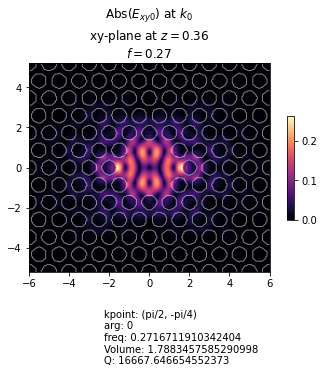

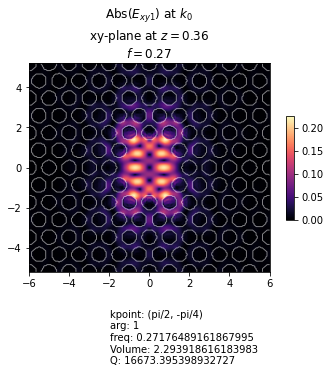

In [24]:
for i in range(arg_list.size):
    fig=legume.viz.field(cma.gme,'E', 0, arg_list[i],z=dslab/2, component='xy', val='abs', N1=200, N2=200, norm=True)
    fig.text(0.5,-0.25,
             "kpoint: (pi/2, -pi/4)" +"\n"
             + "arg: " + str(arg_list[i])+ "\n"
             + "freq: " + str(cma.gme.freqs[0][arg_list[i]]) + "\n"
             + "Volume: " + str(V[i]) + "\n"
             + "Q: " + str(Q[i]))

    fig.savefig("C:\\Users\\stephen\\PycharmProjects\\legume\\Cavity Docs\\Analysis Pics\\kpoint_(pi_2_-pi_4)" + "-freq_" + str(int(cma.gme.freqs[0][arg_list[i]]*1000))
             + "-"+str(time.time_ns())[5:-8], bbox_inches="tight")

And a third

In [25]:
kpoints = np.array([[0], [0]])

cma.gme.run(kpoints=kpoints, **options)

arg_list =np.argwhere((cma.gme.freqs[0]<(band_gaps[0][1]))*(cma.gme.freqs[0]>band_gaps[0][0])).flatten()


V=[]
for arg in arg_list:
    V.append(cma.mode_volume(cma.gme, 'h', 'z', 0, arg, sample_scale=2))

V = np.array(V)

arg_list = arg_list[np.argwhere(V < 10).flatten()]
V = V[np.argwhere(V < 10).flatten()]

freqs_im, _, _ = cma.gme.compute_rad(kind=0, minds=arg_list)

Q = cma.gme.freqs[0][arg_list]/(2*freqs_im[0])

543.5616s total time for real part of frequencies, of which
  1.2940s for guided modes computation using the gmode_compute='exact' method
  0.0000s for inverse matrix of Fourier-space permittivity
  66.7326s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


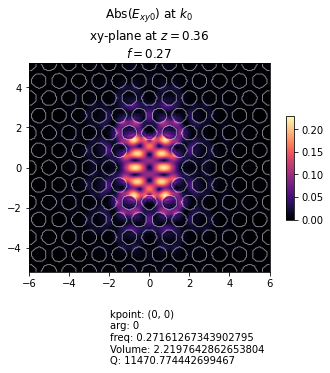

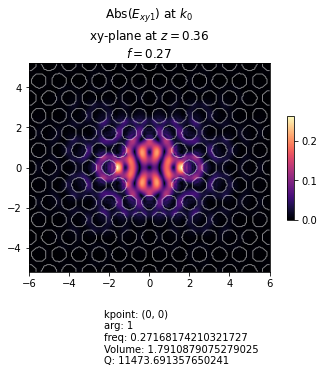

In [26]:
for i in range(arg_list.size):
    fig=legume.viz.field(cma.gme,'E', 0, arg_list[i],z=dslab/2, component='xy', val='abs', N1=200, N2=200, norm=True)
    fig.text(0.5,-0.25,
             "kpoint: (0, 0)" +"\n"
             + "arg: " + str(arg_list[i])+ "\n"
             + "freq: " + str(cma.gme.freqs[0][arg_list[i]]) + "\n"
             + "Volume: " + str(V[i]) + "\n"
             + "Q: " + str(Q[i]))

    fig.savefig("C:\\Users\\stephen\\PycharmProjects\\legume\\Cavity Docs\\Analysis Pics\\kpoint_(0_0)" + "-freq_" + str(int(cma.gme.freqs[0][arg_list[i]]*1000))
             + "-"+str(time.time_ns())[5:-8], bbox_inches="tight")